In [ ]:
pip install --upgrade tensorflow tensorflow-io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 9.1 MB/s eta 0:00:00


In [ ]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

In [ ]:
# Function for inporting data
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)

    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)

    return data_path, data_labels


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"berkekaradumann","key":"8283b4661f848d876de1cadbb70e5def"}'}

In [ ]:
!pip install kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/.kaggle'
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/Tr-g

In [ ]:
# Setting up file paths for training and testing
# USER_PATH = r"/input/brain-tumor-mri-dataset"
USER_PATH = r""
train_dir = USER_PATH + r'Training/'
test_dir = USER_PATH + r'Testing/'

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


Training Counts
{'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}

Testing Counts
{'pituitary': 300, 'notumor': 405, 'meningioma': 306, 'glioma': 300}


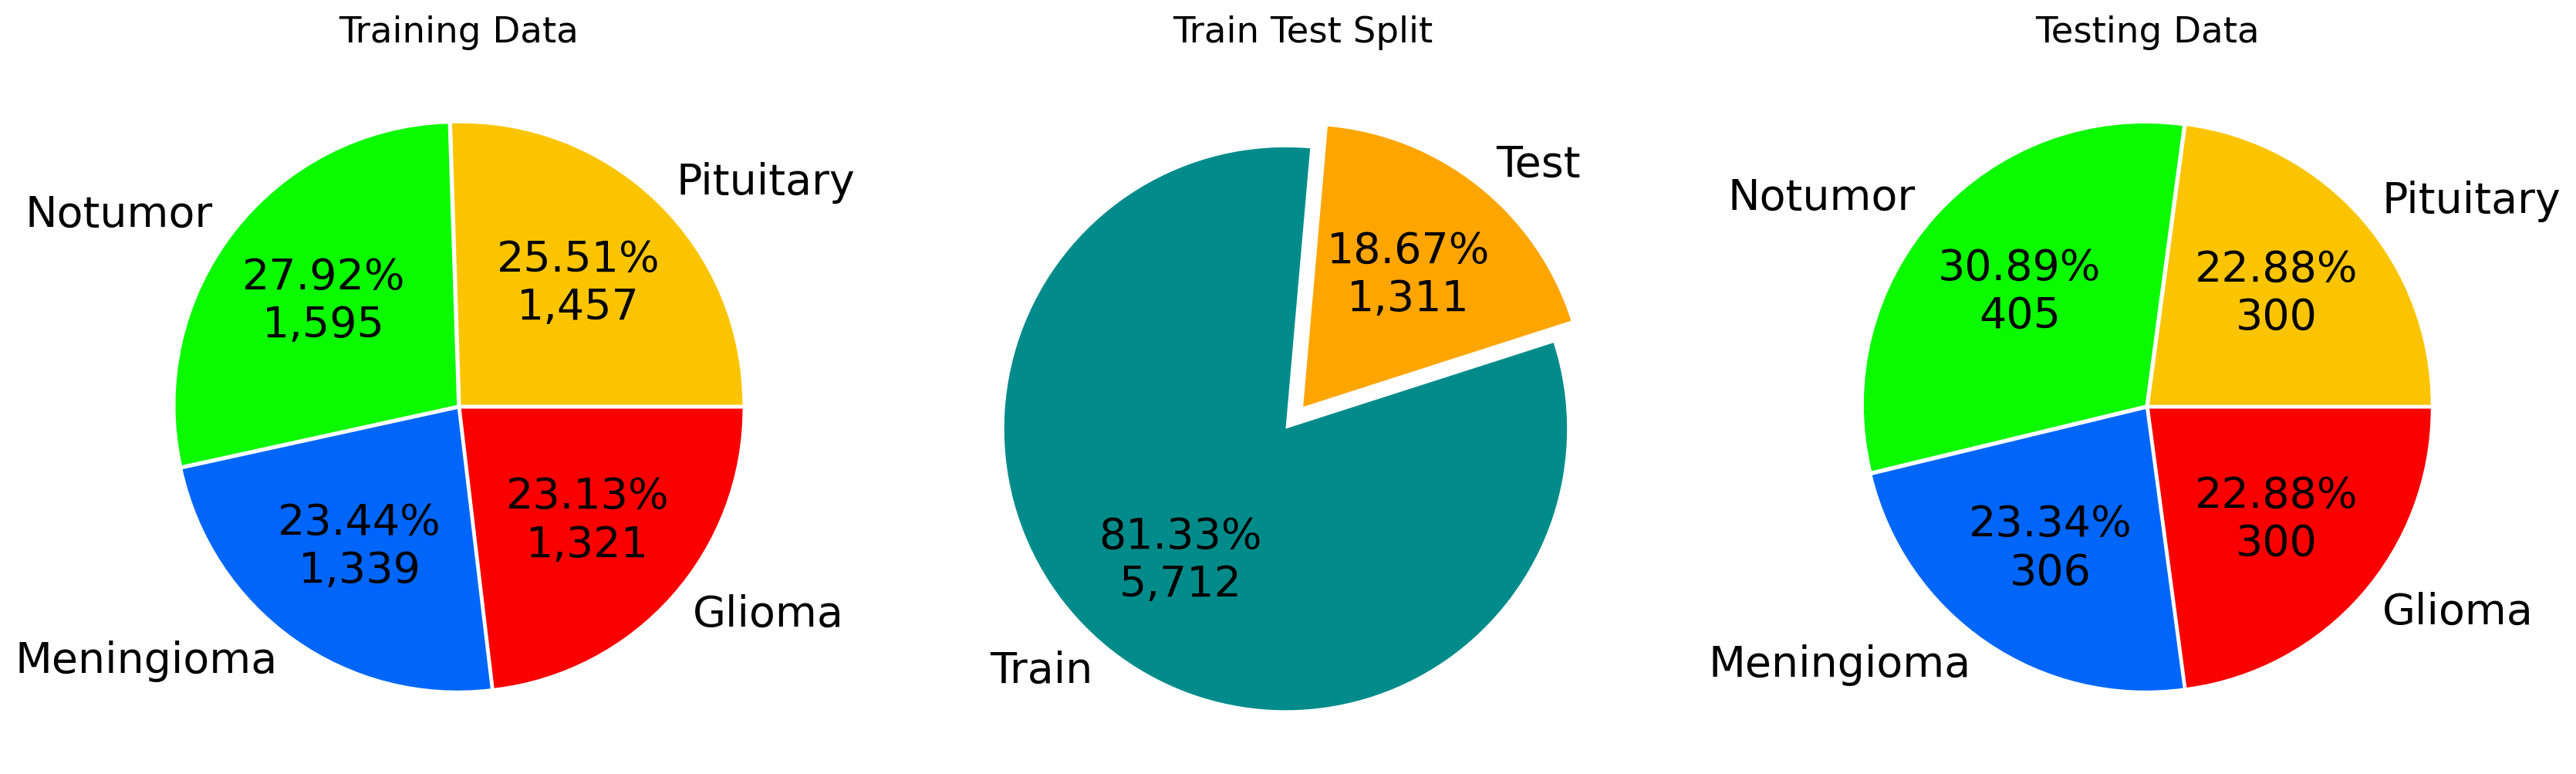

In [ ]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_labels if x == label]) for label in CLASS_TYPES]
print('Training Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_labels), len(test_labels)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_labels), len(test_labels)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_labels if x == label]) for label in CLASS_TYPES]
print('\nTesting Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),  # Explode the slices slightly for better visualization
    textprops={'fontsize': 20}  # Set the font size for the text on the pie chart
)


plt.show()

x reshaped: (1, 150, 150, 3)


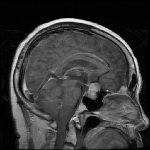

In [ ]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [ ]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a given path based on the inputted
    list indices related to the desired images one wishes
    to see.
    """

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4

    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break

        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths[index]}')
        ax[i].axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()


In [ ]:
# Four different data classification images, from three different angles (images are independent)
show_images(train_paths, train_labels, im_size=350, figsize=(13,10),
            index_list=[0, 94, 235, 17,
                        61, 324, 55, 45,
                        374, 65, 391, 488])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
def show_ImageDataGenerator(data_generator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to visualize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    augmented_samples = next(data_generator)

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()

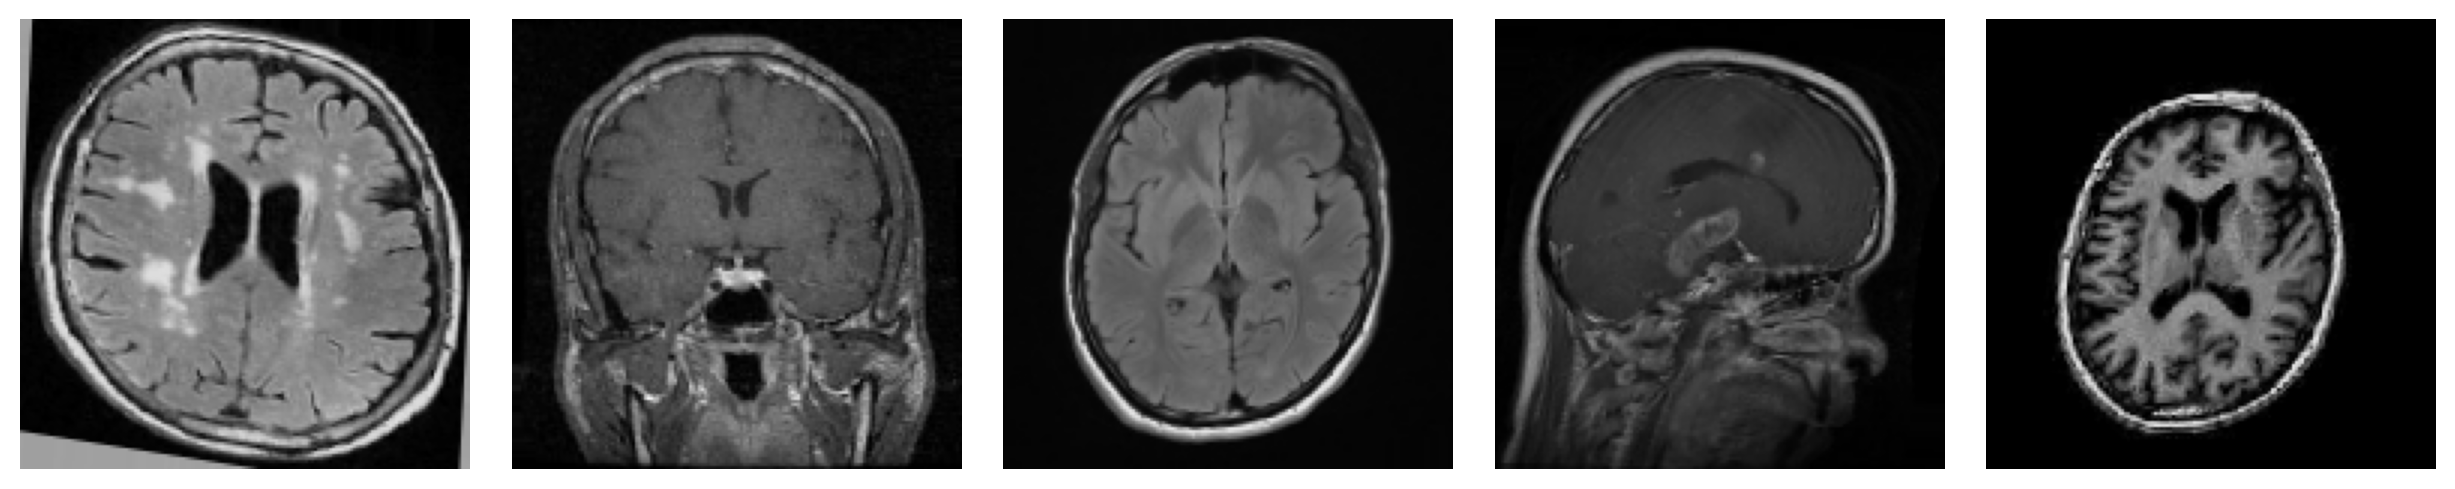

In [ ]:
SAVE = False
show_ImageDataGenerator(train_generator, num_samples=5, figsize=(12.5, 8), save=SAVE)

In [ ]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


In [ ]:
def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(12, 8)):
    """
    Nice display of prediction samples to see CNN predictions
    for classification.
    """
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)

    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")

        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)

    plt.tight_layout()
    plt.show()


def CM(CNN_model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)

    return confusion_matrix_array


def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")


In [ ]:
# Define the model architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
def build_model(input_shape, num_classes):
    model = Sequential([
        # Convolutional layer 1
        Conv2D(32, (4, 4), activation="relu", input_shape=input_shape),
        MaxPooling2D(pool_size=(3, 3)),

        # Convolutional layer 2
        Conv2D(64, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),

        # Convolutional layer 3
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),

        # Convolutional layer 4
        Conv2D(128, (4, 4), activation="relu"),
        Flatten(),

        # Fully connected layers
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    return model

image_shape = (150, 150, 3)  # Örnek giriş boyutu, kendi verinize göre ayarlayın
num_classes = 4  # Örnek sınıf sayısı, kendi verinize göre ayarlayın
model = build_model(image_shape, num_classes)

model.summary()

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 147, 147, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 1, 1, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 34.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


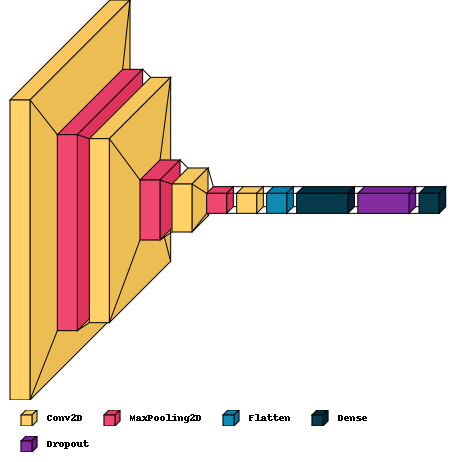

In [ ]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)


In [ ]:
# model_visual = models.Model(inputs=model.input, outputs=model.output)

# # Save model architecture to a file
# plot_model(model_visual, show_dtype=True, to_file='model_architecture.png', show_shapes=True)

# # Display model architecture in the notebook

# from IPython.display import Image
# Image(retina=True, filename='model_architecture.png')

In [ ]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 59s 274ms/step - accuracy: 0.4808 - loss: 1.0939 - val_accuracy: 0.7125 - val_loss: 0.7076 - learning_rate: 0.0010
Epoch 2/40
  1/178 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7188 - loss: 0.5228

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7188 - loss: 0.5228 - val_accuracy: 0.9355 - val_loss: 0.3680 - learning_rate: 0.0010
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 47s 254ms/step - accuracy: 0.7755 - loss: 0.5404 - val_accuracy: 0.7664 - val_loss: 0.6801 - learning_rate: 0.0010
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - accuracy: 0.8438 - loss: 0.4552 - val_accuracy: 0.9677 - val_loss: 0.2341 - learning_rate: 0.0010
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 78s 234ms/step - accuracy: 0.8314 - loss: 0.4297 - val_accuracy: 0.8172 - val_loss: 0.4949 - learning_rate: 0.0010
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9062 - loss: 0.2518 - val_accuracy: 1.0000 - val_loss: 0.0471 - learning_rate: 0.0010
Epoch 7/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 45s 243ms/step - accuracy: 0.8777 - loss: 0.3154 - val_accuracy: 0.8039 - val_loss: 0.6662 - learning_rate: 0.0010
Epoch 8/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - accuracy: 0.8125 - loss: 0.3652 

In [ ]:
# Evaluating the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9721 - loss: 0.0745
Test Loss: 0.04870
Test Accuracy: 0.97969


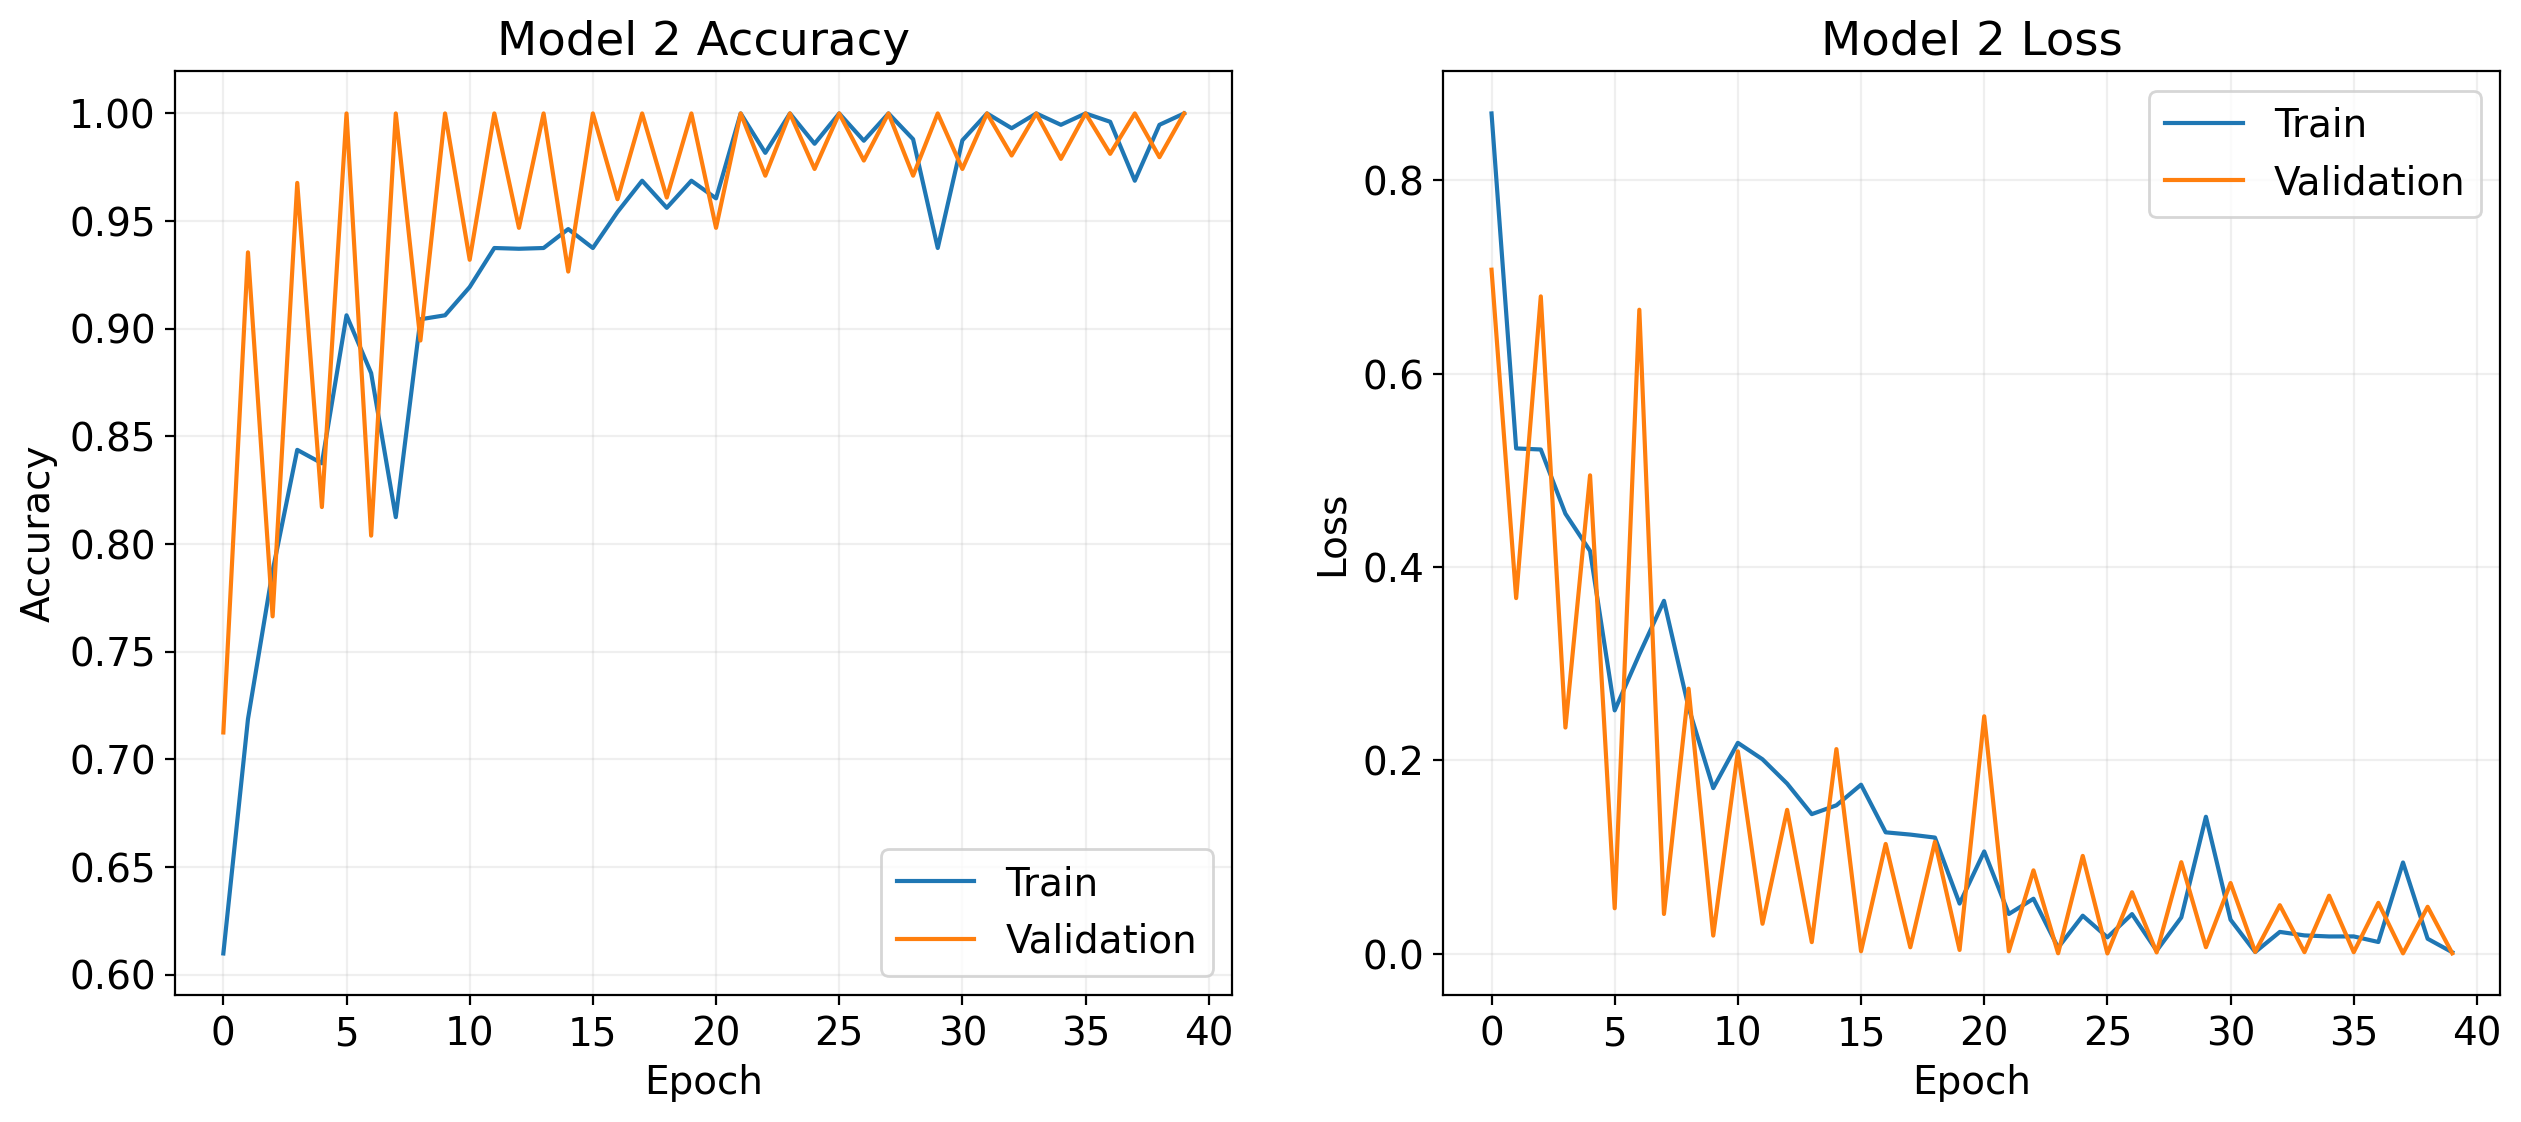

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step


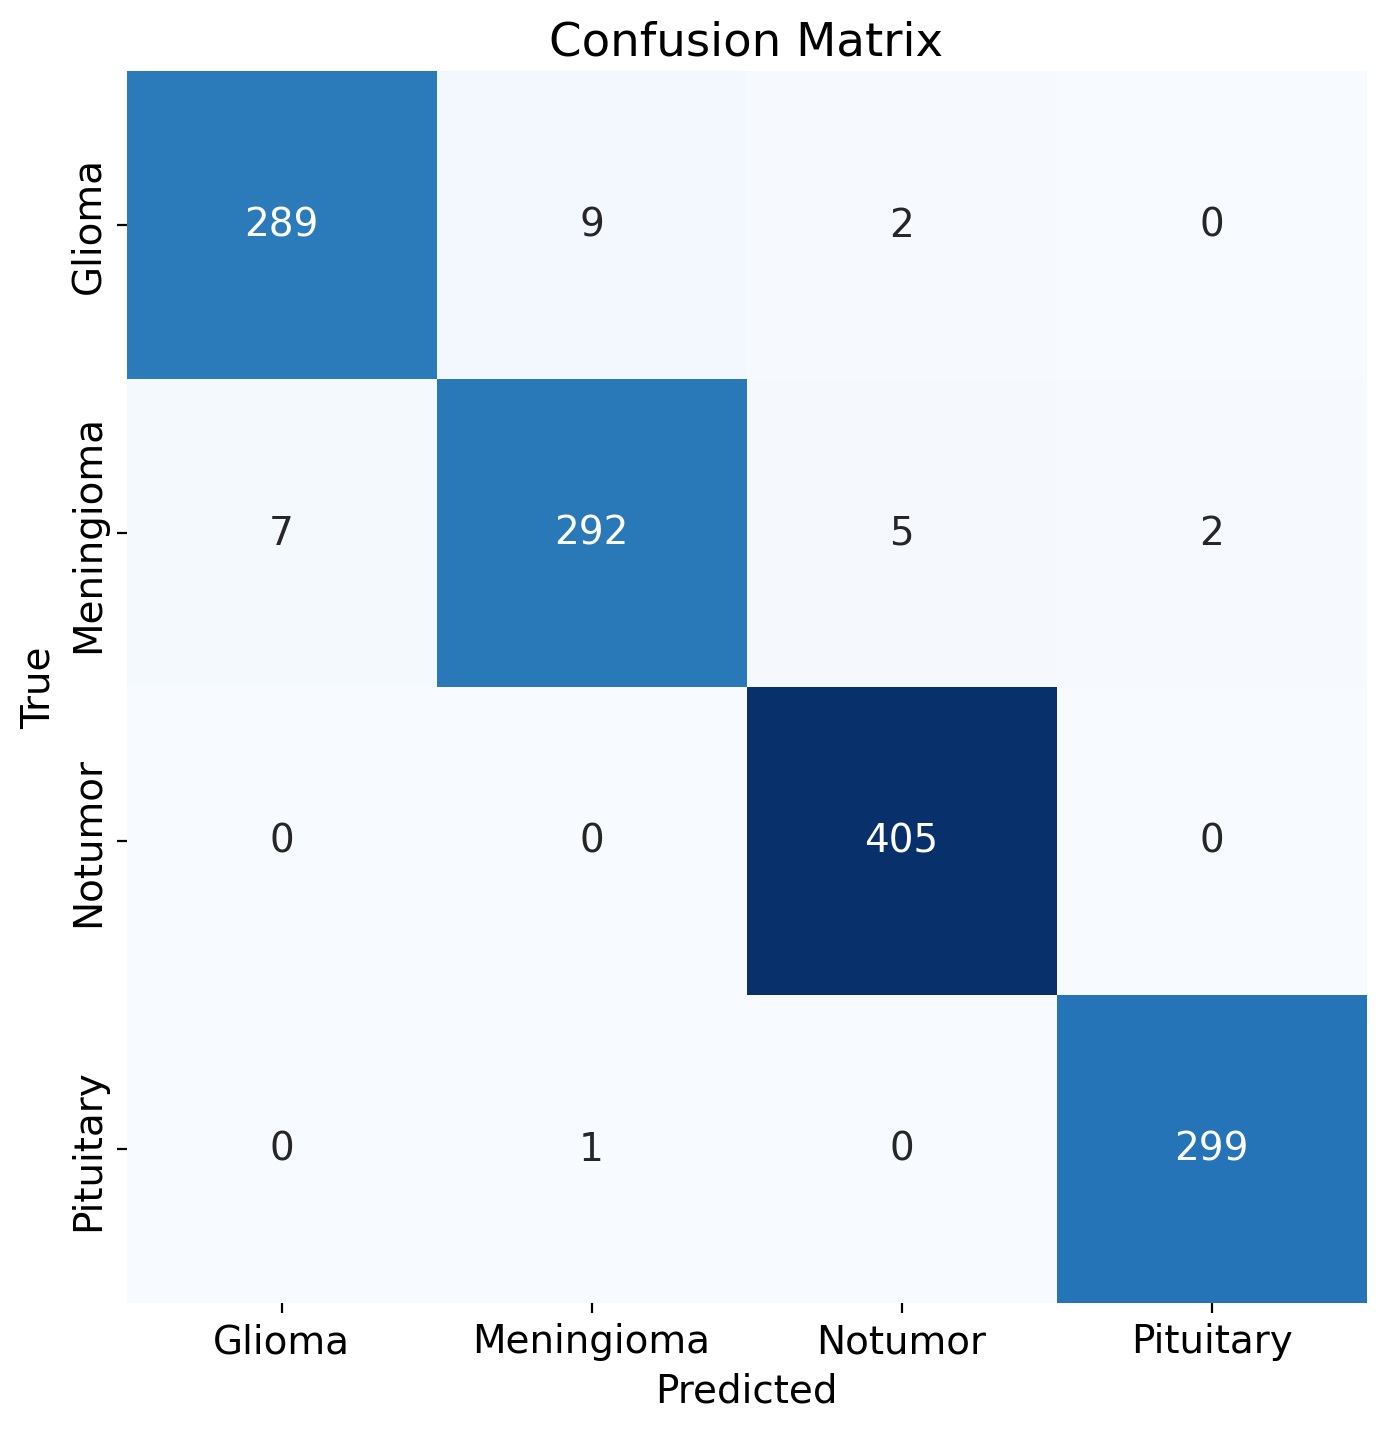

In [ ]:
# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()

In [ ]:
# Showing metrics
calculate_metrics(confusion_matrix, categories=class_indices_train_list)

Class: Glioma
Precision: 0.976
Recall: 0.963
F1-Score: 0.970

Class: Meningioma
Precision: 0.967
Recall: 0.954
F1-Score: 0.961

Class: Notumor
Precision: 0.983
Recall: 1.000
F1-Score: 0.991

Class: Pituitary
Precision: 0.993
Recall: 0.997
F1-Score: 0.995


Accuracy: 0.980


In [ ]:
# Using functions in 6.1 for showing results
plot_sample_predictions(model=model,
                        test_generator=test_generator,
                        categories=class_indices_train_list,
                        test_dir=test_dir,
                        num_samples=9,
                        figsize=(13, 12))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# channnel map plot
def plot_channel_activation_maps(model, image, images_per_row=16, N=8, save=False):
    """
    Function to visualize how the first N layers of the model observe the input image.

    Parameters:
        model (tensorflow.keras.models.Model): The Keras model for which to visualize the activation maps.
        image (numpy.ndarray): The input image for which to generate activation maps.
        images_per_row (int): Number of activation maps to display per row in the grid.
        N (int): Number of layers to visualize.
        save (bool): If True, save the plots as PDF files.

    Returns:
        None
    """
    from tensorflow.keras.models import Model

    # Create a sub-model that outputs activations for the first N layers
    activation_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers[:N]])
    activations = activation_model.predict(image)

    # Get the names of the layers for labeling the plots
    layer_names = [layer.name for layer in model.layers[:N]]

    # Visualize the feature maps for each layer
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]
        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]
        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                epsilon = 1e-8  # A small epsilon value to avoid division by zero
                channel_std = channel_image.std() + epsilon
                channel_image /= channel_std
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size,
                             row * size: (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

        if save:
            plt.savefig(f'plot_channel_activation_maps_{layer_name}.pdf')

    plt.show()

Class name of the first image: glioma
Shape (1, 150, 150, 3)


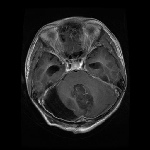

In [ ]:
# Get the next batch from the test generator
batch_images, batch_labels = next(test_generator)

# Extract the first image from the batch
image, label = batch_images[0], batch_labels[0]
image_tensor = np.expand_dims(image, axis=0)

# Get the class indices from the test generator
class_indices = test_generator.class_indices

# Convert the one-hot encoded label to the class name
label_name = [k for k, v in class_indices.items() if np.argmax(label) == v][0]

# Display the class name
print(f"Class name of the first image: {label_name}")
print(f'Shape {image_tensor.shape}')
array_to_img(image_tensor[0])

In [ ]:
plot_channel_activation_maps(model=model, image=image_tensor, N=5, save=SAVE)

In [ ]:
# Visualization of mis-classsified images
def visualize_misclassified_images(model, test_generator, class_indices):
    """
    Visualize misclassified images from the test set alongside their predicted and true labels.

    Parameters:
        model (tensorflow.keras.models.Model): The trained Keras model.
        test_generator (tensorflow.keras.preprocessing.image.DirectoryIterator): The test data generator.
        class_indices (dict): Dictionary mapping class names to their corresponding integer labels.

    Returns:
        None
    """

    from tensorflow.keras.preprocessing.image import array_to_img

    misclassified_images = []
    misclassified_labels_true = []
    misclassified_labels_pred = []

    for i in range(len(test_generator)):
        batch_images, batch_labels = next(test_generator)
        batch_predictions = model.predict(batch_images, verbose=False)
        predicted_labels = [list(class_indices.keys())[np.argmax(pred)] for pred in batch_predictions]
        true_labels = [list(class_indices.keys())[np.argmax(label)] for label in batch_labels]

        for j in range(len(batch_images)):
            if predicted_labels[j] != true_labels[j]:
                misclassified_images.append(batch_images[j])
                misclassified_labels_true.append(true_labels[j])
                misclassified_labels_pred.append(predicted_labels[j])

    # Display misclassified images alongside their true and predicted labels
    num_misclassified = len(misclassified_images)
    num_rows = int(np.ceil(num_misclassified / 4))
    plt.figure(figsize=(12, 3 * num_rows))

    for i in range(num_misclassified):
        plt.subplot(num_rows, 4, i + 1)
        plt.title(f"True: {misclassified_labels_true[i]}\nPred: {misclassified_labels_pred[i]}", color='red')
        plt.imshow(array_to_img(misclassified_images[i]))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Using function above
visualize_misclassified_images(model, test_generator, test_generator.class_indices)

Output hidden; open in https://colab.research.google.com to view.